# Adversarial Training 

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
import fbfadvtrain
import activationsf

In [3]:
from tensorflow.keras import layers 
from tensorflow.keras import initializers 
from tensorflow.keras import regularizers 
from tensorflow.keras import losses, optimizers, metrics
from tensorflow.keras import callbacks 
from tensorflow.keras.models import Sequential

In [4]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train/ 255.0, x_test/ 255.0

In [5]:
from tensorflow.keras.activations import elu

In [10]:
tf.keras.mixed_precision.experimental.set_policy('mixed_float16')
kaf_elu_cnn = Sequential([
  
  # VGG inspired model: 
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform',  input_shape = (32, 32, 3)),
  layers.BatchNormalization(),
  activationsf.Kaf(D=20, conv=True, ridge=elu, name="kaf_1"),

  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(D=20, conv=True, ridge=elu, name="kaf_2"),

  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2, seed=42),

  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(D=20, conv=True, ridge=elu, name="kaf_3"),

  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(D=20, conv=True, ridge=elu, name="kaf_4"),

  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.25, seed=42),

  layers.Conv2D(128, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(D=20, conv=True, ridge=elu, name="kaf_5"),

  layers.Conv2D(128, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(D=20, conv=True, ridge=elu, name="kaf_6"),

  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.3, seed=42),

  tf.keras.layers.Flatten(),
  layers.Dense(128, activation=None, kernel_regularizer=regularizers.l2(0.0012)),
  activationsf.Kaf(D=20, ridge=elu, name="kaf_7"),

  layers.Dropout(0.4, seed=42),
  layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.0012))
])

In [11]:
kaf_elu_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
kaf_1 (Kaf)                  (None, 32, 32, 32)        660       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
kaf_2 (Kaf)                  (None, 32, 32, 32)        660       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)       

In [7]:
from tensorflow.keras.utils import plot_model

In [8]:
tf.keras.utils.plot_model(
    elu_cnn, to_file='basearch.png'
)

Exception: "dot" not found in path.

In [12]:
rob_kaf_elu_cnn = fbfadvtrain.FastBetterFreeTrainedModel(inputs=kaf_elu_cnn.inputs, outputs=kaf_elu_cnn.outputs)

In [13]:
rob_kaf_elu_cnn.compile(
              optimizer = tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
              )

Epoch 1/10
391/391 [==============================] - 34s 88ms/step - loss: 5.0097 - accuracy: 0.0104
Epoch 2/10
391/391 [==============================] - 34s 87ms/step - loss: 3.6086 - accuracy: 0.0987
Epoch 3/10
391/391 [==============================] - 34s 86ms/step - loss: 3.5570 - accuracy: 0.0968
Epoch 4/10
391/391 [==============================] - 34s 86ms/step - loss: 3.4669 - accuracy: 0.0997
Epoch 5/10
391/391 [==============================] - 34s 86ms/step - loss: 3.3232 - accuracy: 0.0979
Epoch 6/10
391/391 [==============================] - 34s 86ms/step - loss: 3.1457 - accuracy: 0.1076
Epoch 7/10
391/391 [==============================] - 34s 87ms/step - loss: 3.0322 - accuracy: 0.1202
Epoch 8/10
391/391 [==============================] - 34s 86ms/step - loss: 3.3356 - accuracy: 0.1348
Epoch 9/10
391/391 [==============================] - 34s 86ms/step - loss: 4.3894 - accuracy: 0.1246
Epoch 10/10
391/391 [==============================] - 34s 86ms/step - loss: 15.01

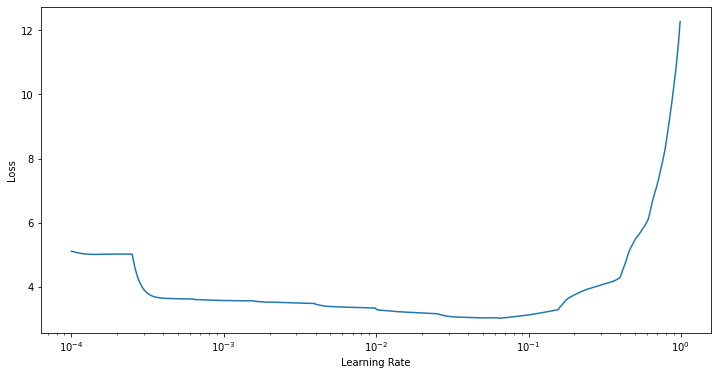

In [9]:
# Find the min max lr meaningful bounds to cycle through
# Ref: https://www.machinecurve.com/index.php/2020/02/25/training-your-neural-network-with-cyclical-learning-rates/
#!git clone https://github.com/WittmannF/LRFinder.git

from LRFinder.keras_callback import LRFinder
lr_finder = LRFinder(min_lr=1e-4, max_lr=1) # implemented as a callback

# Perform lr range test on 10 epochs
rob_elu_cnn.fit(x_train, y_train, epochs = 10,batch_size=128, callbacks=[lr_finder])

 From the plot we want to cycle within 2e-4 8e-2 (Note: restart the kernel and skip this lr finder step)

In [14]:
# Set up cyclic learning (linear)
# ref: same as above
#!git clone https://github.com/bckenstler/CLR.git
from CLR.clr_callback import CyclicLR

# Set CLR options
step_size = int(5 * (50000/128))
base_lr = 1e-3
max_lr = 2e-1
mode='triangular'

# Define the callback
clr = CyclicLR(base_lr=base_lr, max_lr=max_lr, step_size=step_size, mode=mode)

In [15]:
# Set Early Stopping
es = callbacks.EarlyStopping(
        monitor='val_accuracy',
        # "no longer improving" being defined as "no increase greater or equal than 1e-2"
        min_delta=5e-3,
        patience=7,
        mode='max',
        restore_best_weights=True, 
        verbose=1)

In [16]:
# plot diagnostic learning curves
def summarize_diagnostics(history, fine_tuning=False):
	
	if fine_tuning :
		color_train = 'green'
		color_validation = 'red'
	else :
		color_train = 'blue'
		color_validation = 'orange'

	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color=color_train, label='train')
	plt.plot(history.history['val_loss'], color=color_validation, label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color=color_train, label='train')
	plt.plot(history.history['val_accuracy'], color=color_validation, label='test')
	plt.show()
	plt.close()

In [12]:
history_kaf_elu = rob_kaf_elu_cnn.fit(x_train, y_train, epochs = 100, validation_data=(x_test[:2000], y_test[:2000]),batch_size=128, callbacks=[es, clr, activationsf.plot_kafs_epoch_wise(7)])

Epoch 1/100
391/391 [==============================] - 29s 74ms/step - loss: 2.9197 - accuracy: 0.0569 - val_loss: 2.1006 - val_accuracy: 0.2925
Epoch 2/100
391/391 [==============================] - 28s 72ms/step - loss: 2.1724 - accuracy: 0.2250 - val_loss: 1.9495 - val_accuracy: 0.3675
Epoch 3/100
391/391 [==============================] - 28s 73ms/step - loss: 2.0497 - accuracy: 0.2562 - val_loss: 1.8370 - val_accuracy: 0.3915
Epoch 4/100
391/391 [==============================] - 29s 73ms/step - loss: 1.9635 - accuracy: 0.2788 - val_loss: 1.7744 - val_accuracy: 0.4015
Epoch 5/100
391/391 [==============================] - 28s 73ms/step - loss: 1.9034 - accuracy: 0.2919 - val_loss: 1.7114 - val_accuracy: 0.4235
Epoch 6/100
391/391 [==============================] - 28s 73ms/step - loss: 1.8478 - accuracy: 0.3009 - val_loss: 1.6283 - val_accuracy: 0.4430
Epoch 7/100
391/391 [==============================] - 28s 73ms/step - loss: 1.8028 - accuracy: 0.3103 - val_loss: 1.5878 - val_ac

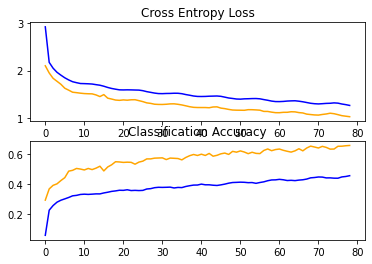

In [13]:
summarize_diagnostics(history_elu)

In [19]:
# Evaluation on pure test/train set
rob_elu_cnn.evaluate(x_train, y_train, batch_size=128)

391/391 [==============================] - 5s 13ms/step - loss: 0.9685 - accuracy: 0.6944


[0.9684995412826538, 0.6944199800491333]

In [20]:
rob_elu_cnn.evaluate(x_test, y_test, batch_size=128)

79/79 [==============================] - 1s 11ms/step - loss: 1.0319 - accuracy: 0.6651


[1.0319467782974243, 0.6650999784469604]

In [16]:
rob_elu_cnn.save('light_custom_models/elu_cnn_robust_fbf') 

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
INFO:tensorflow:Assets written to: light_custom_models/elu_cnn_robust_fbf/assets


In [17]:
rob_elu_cnn = tf.keras.models.load_model('light_custom_models/elu_cnn_robust_fbf')

In [18]:
tf.version.VERSION

'2.3.0-dev20200521'

In [9]:
class logLearningRate(tf.keras.callbacks.Callback):
    """
    Log lr cyclic values within one epoch
    """

    def on_train_batch_begin(self, batch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        tf.print("\nBatch %05d: Learning rate is %6.4f." % (batch, lr), 
        output_stream='file:///tf/thesis/kWTA/Robustness-of-deep-neural-networks-with-trainable-activation-functions/_log.txt')

lr_logger = logLearningRate()

In [10]:
history_elu = rob_elu_cnn.fit(x_train, y_train, epochs = 10,batch_size=128, callbacks=[clr, lr_logger])

Epoch 1/10
391/391 [==============================] - 24s 61ms/step - loss: 2.5286 - accuracy: 0.0829
Epoch 2/10
391/391 [==============================] - 24s 60ms/step - loss: 2.1137 - accuracy: 0.2188
Epoch 3/10
391/391 [==============================] - 24s 60ms/step - loss: 2.0109 - accuracy: 0.2421
Epoch 4/10
391/391 [==============================] - 24s 60ms/step - loss: 1.9537 - accuracy: 0.2538
Epoch 5/10
391/391 [==============================] - 24s 62ms/step - loss: 1.9037 - accuracy: 0.2658
Epoch 6/10
391/391 [==============================] - 25s 63ms/step - loss: 1.8506 - accuracy: 0.2835
Epoch 7/10
391/391 [==============================] - 25s 63ms/step - loss: 1.8103 - accuracy: 0.2916
Epoch 8/10
391/391 [==============================] - 24s 63ms/step - loss: 1.7826 - accuracy: 0.2990
Epoch 9/10
391/391 [==============================] - 25s 63ms/step - loss: 1.7591 - accuracy: 0.3046
Epoch 10/10
391/391 [==============================] - 24s 62ms/step - loss: 1.742

In [13]:
history_elu = rob_elu_cnn.fit(x_train, y_train, epochs = 10,batch_size=128, callbacks=[lr_logger, clr])

Epoch 1/10
391/391 [==============================] - 17s 43ms/step - loss: 2.5730 - accuracy: 0.0673
Epoch 2/10
391/391 [==============================] - 17s 43ms/step - loss: 2.1307 - accuracy: 0.2149
Epoch 3/10
391/391 [==============================] - 17s 43ms/step - loss: 2.0235 - accuracy: 0.2399
Epoch 4/10
391/391 [==============================] - 17s 43ms/step - loss: 1.9699 - accuracy: 0.2523
Epoch 5/10
391/391 [==============================] - 17s 43ms/step - loss: 1.9179 - accuracy: 0.2698
Epoch 6/10
391/391 [==============================] - 17s 43ms/step - loss: 1.8797 - accuracy: 0.2780
Epoch 7/10
391/391 [==============================] - 17s 43ms/step - loss: 1.8547 - accuracy: 0.2866
Epoch 8/10
391/391 [==============================] - 17s 43ms/step - loss: 1.8376 - accuracy: 0.2921
Epoch 9/10
391/391 [==============================] - 17s 43ms/step - loss: 1.8345 - accuracy: 0.2933
Epoch 10/10
391/391 [==============================] - 17s 43ms/step - loss: 1.829

In [5]:
tf.keras.mixed_precision.experimental.set_policy('mixed_float16')
kaf_cnn = Sequential([
  
  # Using KAFs instead
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform',  input_shape = (32, 32, 3)),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=16, name='kaf_1'),
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=16, name='kaf_2'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2, seed=42),

  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=16, name='kaf_3'),
  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=16, name='kaf_4'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.3, seed=42),

  layers.Conv2D(128, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=16, name='kaf_5'),
  layers.Conv2D(128, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=16, name='kaf_6'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.4, seed=42),

  layers.GlobalAveragePooling2D(),
  layers.Dense(128, activation=None, kernel_regularizer=regularizers.l2(0.0012)),
  activationsf.Kaf(D=16, name='kaf_6'),
  layers.Dropout(0.4, seed=42),
  layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.0012), dtype=tf.float32)
])

In [8]:
rob_kaf_cnn = fbfadvtrain.FastBetterFreeTrainedModel(inputs=kaf_cnn.inputs, outputs=kaf_cnn.outputs)

In [10]:
rob_kaf_cnn.compile(
              optimizer = tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
              )

In [11]:
# Again, lets find the min max lr meaningful bounds to cycle through

from LRFinder.keras_callback import LRFinder
lr_finder = LRFinder(min_lr=1e-4, max_lr=1) # implemented as a callback

# Perform lr range test on 10 epochs
rob_kaf_cnn.fit(x_train, y_train, epochs = 10,batch_size=128, callbacks=[lr_finder])

Epoch 1/10
 28/391 [=>............................] - ETA: 7:10 - loss: 2.4453 - accuracy: 0.0940

KeyboardInterrupt: 

In [ ]:
history_kaf = custom_model.fit(x_train, y_train, epochs = 1, validation_data=(x_test, y_test),batch_size=64)

In [ ]:
x_train.shape

In [ ]:
kaf_cnn.outputs

In [ ]:
kaf_cnn_art = fbfadvtrain.FastBetterFreeTrainedModel(kaf_cnn)

In [ ]:
kaf_cnn_art.compile(
              optimizer = tf.keras.optimizers.SGD(learning_rate=0.18),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
              )

In [ ]:
history_kaf = kaf_cnn_art.fit(x_train, y_train, epochs = 10, validation_data=(x_test, y_test), callbacks=[activationsf.plot_kafs_epoch_wise(num_layers=5)])

In [ ]:
from art.classifiers import TensorFlowV2Classifier

kaf_cnn_art = TensorFlowV2Classifier(model=kaf_cnn, nb_classes=10, input_shape=(32, 32, 3), loss_object=tf.keras.losses.SparseCategoricalCrossentropy(), clip_values=(0, 1))

In [ ]:
trainer = fbfadvtrain.AdversarialTrainerFBFTensorflow2(kaf_cnn_art)

In [ ]:
trainer.fit(x_train, y_train, nb_epochs = 10, batch_size=64)

In [ ]:
history_kaf = kaf_cnn.fit(x_train[:10000], y_train[:10000], epochs = 20, validation_data=(x_test[:1000], y_test[:1000]), callbacks=[activationsf.plot_kafs_epoch_wise(num_layers=5)])